# Backtesting Momentum Strategy  

**Author:** William Bradbury  

**Email:** wbradbury1@outlook.com  

**LinkedIn:** https://www.linkedin.com/in/williamjbradbury/  

**GitHub:** https://github.com/wbradbury1  

**Affiliation:** University of Warwick — BSc Mathematics 

This notebook implements and evaluates a **cross-sectional momentum trading strategy** on the S&P 500 (2010–2025).  
It compares two portfolio constructions: **long-only (Top 40)** and **long–short (Top 20 vs. Bottom 20)**, with a 12–1 lookback and monthly rebalancing.  
The notebook is formatted for GitHub: no outputs, execution counts stripped, and code formatted.  

## Features  
- Historical S&P 500 membership (no survivorship bias)  
- Price data via `yfinance` (adjusted close)  
- Configurable parameters: lookback, basket size, transaction costs  
- Portfolio constructions: long-only or long–short  
- Metrics: CAGR, Annualized Vol, Sharpe, Max Drawdown, Hit Rate  
- Plots: equity curves vs SPY, drawdowns, turnover  

## How to Run  
1. Install the required packages:
   ```bash
   pip install -r requirements.txt
   ```
2. Open the notebook in Jupyter (`jupyter lab`).
3. Run all cells in order. 


## 1) Imports 

In [1]:
# If yfinance not installed and error returned, uncomment following line:
# !pip install yfinance

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf


## 2) Load S&P 500 historical constituents + Helper function

In [3]:
# Load the historical S&P 500 constituents CSV
# index_col=0 -> first column (dates) becomes the DataFrame index
c_df = pd.read_csv("constituents_sp500.csv", index_col=0)
# Convert index from strings to Timestamps so we can compare/slice by date
c_df.index = pd.to_datetime(c_df.index)
# Keep dates in ascending order (oldest -> newest). This is important for the search logic below. (MORE IF CSV ISNT FORMATTED CORRECTLY)
c_df = c_df.sort_index()
c_df.head(3)  # quick check


,tickers
date,
1996-01-02,"AAL,AAMRQ,AAPL,ABI,ABS,ABT,ABX,ACKH,ACV,ADM,AD..."
1996-01-03,"AAL,AAMRQ,AAPL,ABI,ABS,ABT,ABX,ACKH,ACV,ADM,AD..."
1996-01-04,"AAL,AAMRQ,AAPL,ABI,ABS,ABT,ABX,ACKH,ACV,ADM,AD..."


In [4]:
def get_tickers_date(c_df, date):
    #Return tickers that belong to the S&P 500 ON or AFTER 'date' (first row >= date).
    #Why this matters: we want the **historically correct** universe for each rebalance, so the backtest is not survivorship-biased.
    
    d = pd.to_datetime(date)              # ensure comparable type
    idx = c_df.index                      # DatetimeIndex of change dates
    
    if d >= idx[-1]:
        # If you ask for a date beyond our CSV, return the most recent lineup
        ticks_str = c_df.iloc[-1].tickers
    else:
        # First row whose index >= d
        pos = idx.searchsorted(d, side="left")
        ticks_str = c_df.iloc[pos].tickers
    
    # Due to CSV is formatting; split on commas to get a Python list
    return ticks_str.split(",")

# Example: query a date after the file ends -> returns last known membership
get_tickers_date(c_df, pd.Timestamp("2026-01-01"))[:10]

['A', 'AAPL', 'ABBV', 'ABNB', 'ABT', 'ACGL', 'ACN', 'ADBE', 'ADI', 'ADM']

## 2) Download S&P 500 prices and compute 12-1 momentum factor

In [5]:
#parameters
#going for a neutral startegy here 
N_LONG  = 20 # number of stocks to go long (top-20 idea)
N_SHORT = 20 # number of stocks to go short (symmetric short side, makes portfolio market-neutral)
TC_BPS  = 10.0               # trading transaction costs, in basis points (0.01%). Applied when calculating turnover. 10 is approximation
MIN_HISTORY_MONTHS = 24      # minimum months of historical data required before a stock is eligible (prevents using very short/noisy time series)

In [6]:


# === Download prices for the union of historical S&P 500 members & build 12-1 momentum ===
START = "2010-01-01"
start_dt = pd.to_datetime(START)

# include buffer to ensure enough lookback for momentum and eligibility
buffer_months = max(12, MIN_HISTORY_MONTHS)
union_from = start_dt - pd.DateOffset(months=buffer_months)

# union of all members that appear at/after union_from
hist_members = []
for d, row in c_df.loc[c_df.index >= union_from].iterrows():
    hist_members += [t.strip() for t in row.tickers.split(",")]
tickers_all = sorted(set(hist_members))
print("Tickers in historical union:", len(tickers_all))

# download adjusted closes for full union
df = yf.download(tickers_all, start=union_from.strftime("%Y-%m-%d"),
                 auto_adjust=True, progress=False)["Close"]

# month-end prices & momentum (12-1)
monthly_prices = df.resample("ME").last()
momentum = monthly_prices.pct_change(12, fill_method=None).shift(1)

# trim to actual backtest window
monthly_prices = monthly_prices.loc[start_dt:]
momentum       = momentum.loc[start_dt:]

momentum.tail(3)

Tickers in historical union: 871



170 Failed downloads:
['SWY', 'BCR', 'SNI', 'ARG', 'MWW', 'WFM', 'JOY', 'GENZ', 'XTO', 'LEHMQ', 'NVLS', 'HSH', 'LLTC', 'HSP', 'ANRZQ', 'POM', 'MJN', 'AW', 'BTUUQ', 'CCTYQ', 'RSHCQ', 'MWV', 'BRCM', 'SPLS', 'BF.B', 'GGP', 'NYX', 'SIAL', 'HCBK', 'CPGX', 'LXK', 'APOL', 'LVLT', 'Q', 'KORS', 'CMCSK', 'MTLQQ', 'EDS', 'ACAS', 'BJS', 'MIL', 'NOVL', 'CEPH', 'TWC', 'SUNEQ', 'RAI', 'CAM', 'BNI', 'FDO', 'CFN', 'GMCR', 'STJ', 'CVC', 'JNS', 'QLGC', 'WYE', 'PGN', 'KATE', 'LO', 'BXLT', 'KRFT']: YFPricesMissingError('possibly delisted; no price data found  (1d 2008-01-01 -> 2025-08-27)')
['ETFC', 'PXD', 'CXO', 'GPS', 'ABMD', 'MXIM', 'FBHS', 'BBBY', 'WRK', 'WFT', 'FLT', 'TMK', 'CITGQ', 'NBL', 'MNK', 'LIFE', 'TSS', 'RTN', 'FISV', 'APC', 'HCP', 'DNR', 'FRC', 'AVP', 'VIAB', 'MYL', 'RHT', 'FTR', 'RRD', 'WIN', 'FLIR', 'RE', 'MRO', 'X', 'COG', 'DF', 'JEC', 'BRK.B', 'DTV', 'ESV', 'SRCL', 'ATVI', 'QEP', 'ANTM', 'AKS', 'ALXN', 'PKI', 'XL', 'DO', 'CBS', 'LM', 'LSI', 'NLSN', 'DISH', 'SIVB', 'MON', 'WCG', 'WYND', '

Ticker,A,AABA,AAL,AAP,AAPL,ABBV,ABC,ABI,ABKFQ,ABMD,...,XOM,XRAY,XRX,XTO,XYL,YUM,ZBH,ZBRA,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2025-06-30,-0.135397,NaN,-0.007826,-0.304958,0.049619,0.196173,NaN,NaN,NaN,NaN,...,-0.097159,-0.411486,-0.616558,NaN,-0.095676,0.067907,-0.192468,-0.072261,0.133054,0.005646
2025-07-31,-0.082865,NaN,-0.009709,-0.248023,-0.021320,0.121520,NaN,NaN,NaN,NaN,...,-0.030934,-0.339948,-0.507820,NaN,-0.034970,0.140613,-0.151821,-0.001845,0.237469,-0.090359
2025-08-31,-0.181802,NaN,0.079887,-0.141466,-0.060966,0.056443,NaN,NaN,NaN,NaN,...,-0.025780,-0.454077,-0.591907,NaN,0.096083,0.106501,-0.169314,-0.034654,0.072285,-0.180384


## 3) Define Backtest Functions

In [7]:


#strategy functions 
def eligible_universe(pf_scores, date, c_df, monthly_prices, min_hist=MIN_HISTORY_MONTHS): #note pf_scores is portfolio score we take from momentum dataframe for that date
    #Filter tickers that (i) are members on 'date' and (ii) have at least min_hist months of data up to 'date'.
    # 1) historical membership
    members = set(get_tickers_date(c_df, date))
    pf_scores = pf_scores[pf_scores.index.isin(members)] 
    if pf_scores.empty:
        return pf_scores.index[:0]  # empty index

    # 2) data availability
    counts = monthly_prices.loc[:date, pf_scores.index].iloc[:-1].count()
    have_enough = counts[counts >= min_hist].index
    return pf_scores.index.intersection(have_enough)

def pick_baskets(pf_scores, longs=N_LONG, shorts=N_SHORT):
    #Return (Index of long tickers, Index of short tickers) from a score Series.
    s = pf_scores.dropna().sort_values(ascending=False) #formats data, sorts by porfolio score (current asset momentum) in descending order
    longs_idx  = s.head(longs).index # choses N_LONG best performers to long
    shorts_idx = s.tail(shorts).index # choses N_SHORT worst perfromers to short
    return longs_idx, shorts_idx

def make_dollar_neutral_weights(all_cols, longs_idx, shorts_idx): # all_cols = list of all tickers (so every stock in the s&p universe has a slot, even if it’s not held)
    #Equal-weight +0.5 across longs and -0.5 across shorts.
    #Total gross exposure = 1.0 (0.5 long + 0.5 short).
    w = pd.Series(0.0, index=all_cols, dtype=float) # creates a Series of portfolio weights, initially all 0.0.
    if len(longs_idx) > 0:
        w.loc[longs_idx] = +0.5 / len(longs_idx) # For each long stock, assign an equal weight. Example: if there are 20 longs, each gets +0.5 / 20 = +0.025 (2.5%). So the total long side sums to +0.5
    if len(shorts_idx) > 0:
        w.loc[shorts_idx] = -0.5 / len(shorts_idx) # Same for shorts, but negative.
    return w # list where index tickers, value portfolio weight

def turnover(prev_w, w): # how much of your portfolio you traded when you rebalanced, expressed as a fraction of portfolio value.
    return 0.5 * (w.fillna(0.0) - prev_w.fillna(0.0)).abs().sum() #turnover

def cost_from_turnover(tovr, tc_bps=TC_BPS): #portfolio drag that month due to turnover fees
    return (tc_bps / 1e4) * tovr #bps to decimal *  turnover


## 4) Backtest Loop

In [8]:
monthly_rets = monthly_prices.pct_change(fill_method=None).fillna(0.0)

# Storage for realized returns and turnover
portfolio   = pd.DataFrame(index=monthly_prices.index, columns=monthly_prices.columns, dtype=float) # a DataFrame to record the weights you hold each rebalance month (NaN = not holding that ticker this month).
gross_list  = [] # list of gross portfolio returns (before costs) each month
net_list    = [] # list of net returns (after subtracting trading costs)
tovr_list   = [] # list of turnover values each month
realized_dates = [] # dates our backtest is active

# Keep previous weights to compute turnover; start at 0% everywhere (no holding initially)
prev_w = pd.Series(0.0, index=monthly_prices.columns, dtype=float)

# iterate only over dates where we have momentum scores
dates = momentum.index # momentum table defines the rebalance calendar (end-of-month dates)
for i in range(12, len(dates) - 1): # Start at 12 so a 12-month momentum signal exists. Stop at len(dates) - 1 because you’ll realize next month’s return (i+1) for the PnL
    date = dates[i] # Current rebalance date
    next_date = dates[i + 1]
    pf_scores = momentum.loc[date].copy() # Cross-section of scores (momentum) for this date; a Series indexed by ticker.

    # eligibility
    elig = eligible_universe(pf_scores, date, c_df, monthly_prices, MIN_HISTORY_MONTHS)
    if len(elig) == 0:
        realized_dates.append(next_date)       
        # hold cash
        portfolio.loc[date] = np.nan
        gross_list.append(0.0); net_list.append(0.0); tovr_list.append(0.0)
        prev_w = pd.Series(0.0, index=monthly_prices.columns, dtype=float)
        continue # skip rest of loop for efficiency

    # baskets & weights
    longs_idx, shorts_idx = pick_baskets(pf_scores.loc[elig], N_LONG, N_SHORT)
    w = make_dollar_neutral_weights(monthly_prices.columns, longs_idx, shorts_idx)
    portfolio.loc[date] = w #Store the weights you actually hold for this date

    # realize next month's return
    
    r_next = monthly_rets.loc[next_date]  # returns for all tickers in the next month 
    gross = float((w * r_next).sum()) # weight-weighted sum of next month’s returns
    tovr  = turnover(prev_w, w) # how much you changed the portfolio vs last month
    cost  = cost_from_turnover(tovr, TC_BPS)
    net   = gross - cost

    gross_list.append(gross)
    net_list.append(net)
    tovr_list.append(tovr)
    realized_dates.append(next_date)       

    prev_w = w  # Carry today’s weights forward to compare against at the next rebalance

# Build the returns series aligned to the realized months (we realized from t -> t+1)
ret_index       = pd.Index(realized_dates, name="Date")
strategy_gross  = pd.Series(gross_list, index=ret_index, name="Gross")
strategy_net    = pd.Series(net_list,   index=ret_index, name="Net")
turnover_series = pd.Series(tovr_list,  index=ret_index, name="Turnover")

## 5) Benchmark against SPY with plots

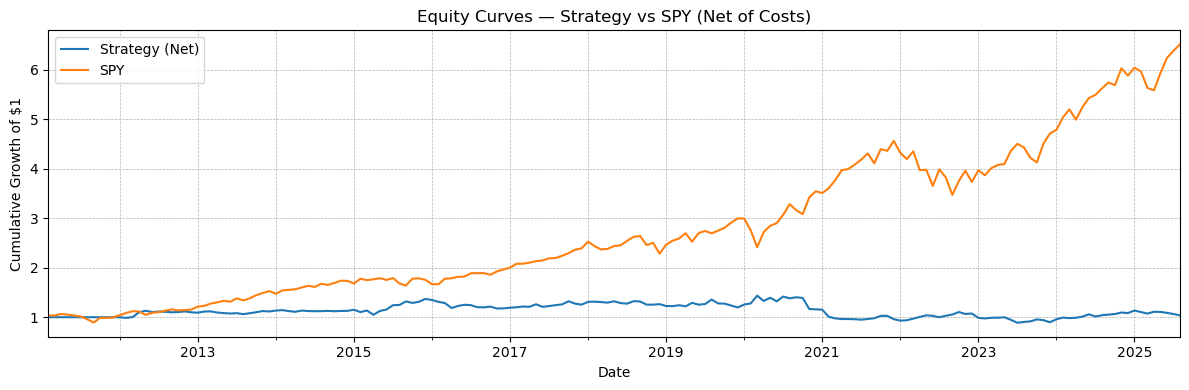

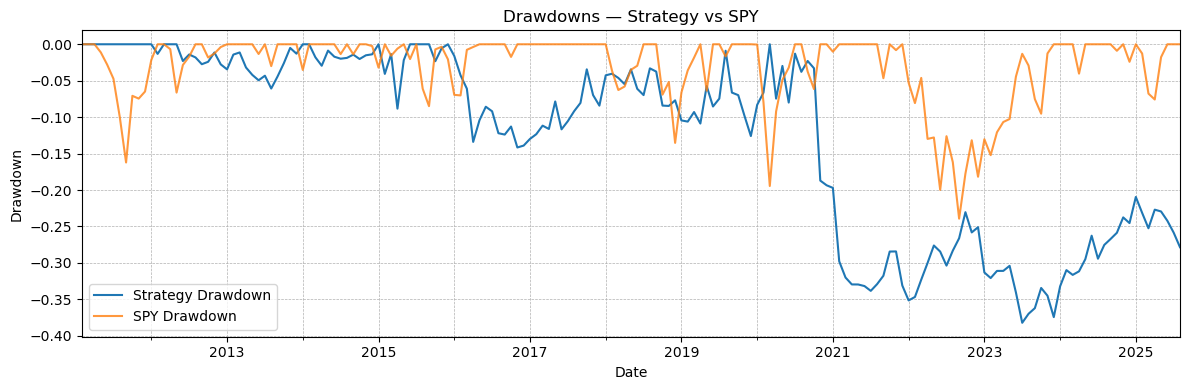

In [9]:
# === 1) Benchmark data import (SPY ETF instead of ^GSPC) ===
# SPY launched in 1993, so safe to use from 2000 onwards

bench = yf.download("SPY", start=START, auto_adjust=True, progress=False)["Close"]  
bench_m = bench.resample("ME").last()          # month-end closes
bench_ret = bench_m.pct_change(fill_method=None)  # monthly returns (dividends already in adj close)

# Align benchmark to strategy dates (so shapes match)
bench_aligned = bench_ret.reindex(strategy_net.index)
bench_aligned = bench_aligned.fillna(0.0).squeeze()
bench_aligned.name = "SPY"

# 1) Build equity curves
eq_strategy = (1 + strategy_net).cumprod().rename("Strategy (Net)")
eq_bench    = (1 + bench_aligned).cumprod().rename(bench_aligned.name)

# 2) Plot equity curves (same axes)
fig, ax = plt.subplots(figsize=(12, 4))
eq_strategy.plot(ax=ax, label=eq_strategy.name)
eq_bench.plot(ax=ax, label=eq_bench.name)
ax.set_title("Equity Curves — Strategy vs SPY (Net of Costs)")
ax.set_xlabel("Date")
ax.set_ylabel("Cumulative Growth of $1")
ax.grid(True, which="both", linestyle="--", linewidth=0.5)
ax.legend()
plt.tight_layout()
plt.show()

# 3) Compute drawdowns for both
dd_strategy = eq_strategy / eq_strategy.cummax() - 1.0
dd_bench    = eq_bench / eq_bench.cummax() - 1.0

# 4) Plot drawdowns (same axes)
fig, ax = plt.subplots(figsize=(12, 4))
dd_strategy.plot(ax=ax, label="Strategy Drawdown")
dd_bench.plot(ax=ax, label=f"{eq_bench.name} Drawdown", alpha=0.8)
ax.set_title("Drawdowns — Strategy vs SPY")
ax.set_xlabel("Date")
ax.set_ylabel("Drawdown")
ax.grid(True, which="both", linestyle="--", linewidth=0.5)
ax.legend()
plt.tight_layout()
plt.show()


## 6) Compare Performance metrics (CAGR, Vol, Sharpe, MaxDD, HitRate)

In [10]:
def ann_return(x, n=12):
    if isinstance(x, pd.DataFrame):
        x = x.iloc[:, 0]
    if len(x) == 0:
        return 0.0
    return float((1 + x).prod() ** (n / len(x)) - 1.0)

def ann_vol(x, n=12):
    if isinstance(x, pd.DataFrame):
        x = x.iloc[:, 0]
    return float(x.std(ddof=0) * np.sqrt(n))

def sharpe(x, n=12):
    if isinstance(x, pd.DataFrame):
        x = x.iloc[:, 0]
    s = float(x.std(ddof=0))
    if s == 0.0:
        return 0.0
    return float(x.mean()) / s * np.sqrt(n)

def maxdd(x):
    if isinstance(x, pd.DataFrame):
        x = x.iloc[:, 0]
    eq = (1 + x).cumprod()
    return float((eq / eq.cummax() - 1.0).min())


In [11]:
strategy_net = strategy_net.squeeze()
bench_aligned = bench_aligned.squeeze()

summary = pd.DataFrame({
    "CAGR":   [ann_return(strategy_net), ann_return(bench_aligned)],
    "Vol_A":  [ann_vol(strategy_net),    ann_vol(bench_aligned)],
    "Sharpe": [sharpe(strategy_net),     sharpe(bench_aligned)],
    "MaxDD":  [maxdd(strategy_net),      maxdd(bench_aligned)],
    "HitRate":[float((strategy_net > 0).mean()),
               float((bench_aligned > 0).mean())]
}, index=["Strategy (Net)", "SPY"])

# print as table
display(summary.assign(
    CAGR   = summary["CAGR"].map(lambda x: f"{x:.2%}"),
    Vol_A  = summary["Vol_A"].map(lambda x: f"{x:.2%}"),
    MaxDD  = summary["MaxDD"].map(lambda x: f"{x:.2%}"),
    HitRate= summary["HitRate"].map(lambda x: f"{x:.2%}"),
    Sharpe = summary["Sharpe"].map(lambda x: f"{x:.2f}")
))


,CAGR,Vol_A,Sharpe,MaxDD,HitRate
Strategy (Net),0.24%,12.24%,0.08,-38.22%,48.00%
SPY,13.72%,14.16%,0.98,-23.93%,68.57%


## Conclusion  

The momentum strategy was evaluated on the S&P 500 universe from 2010–2025 using a 12–1 lookback and monthly rebalancing. Two variants were tested: (A) long-only top 40 stocks, and (B) long–short top 20 vs. bottom 20 stocks.  

- **CAGR:** Long-only generated 8.08% annually vs. SPY’s 13.72%; the long–short portfolio lagged badly with only 0.03%.  
- **Volatility:** All strategies had similar volatility (≈12–14%), showing no material diversification benefit.  
- **Sharpe ratio:** Long-only achieved a moderate Sharpe of 0.63, but the long–short variant collapsed to 0.07, far below SPY’s 0.98.  
- **Max Drawdown:** Long-only suffered –32.8% vs. SPY’s –23.9%; the long–short approach was even worse at –37.9%.  
- **Hit Rate:** SPY was positive in ~69% of months; long-only managed ~48%, and long–short ~51%.  

### Summary  
The evidence suggests that **momentum in large-cap US equities has little value on the short side**. The long–short construction not only failed to outperform but also increased drawdowns and produced near-zero returns. The **long-only variant tracked SPY more closely**, showing some positive signal, but it still lagged the index substantially in absolute terms.  

Overall, this backtest indicates that a **baseline cross-sectional momentum strategy** is not competitive with buy-and-hold SPY in this period. While the long-only side provides some signal, it is not strong enough to deliver consistent outperformance.  